# Notebook 6 - Property modeling with Chemical Checker Signatures

By Vincent Blay, Tijana Radivojevic November 2021 - May 2022

This notebook was developed using **RPReactor 3.8** kernel on [jprime.lbl.gov](https://gpu2.ese.lbl.gov/).

This notebooks illustrates one possible use of the recent [Chemical Checker signatures](https://www.nature.com/articles/s41467-021-24150-4) instead of molecular descriptors to model some of the properties in this work.

Chemical Checker signaturizers generate 128-D numerical vectors that can be used as conventional molecular descriptors. Each signaturizer is trained on a dataset of different nature. Around 800,000 small molecules and associated data were used in the construction of the Chemical Checker. Type I signatures are generated by applying Latent Semantic Indexing (LSI, a form of dimensionality reduction), to datasets of different nature. Type II signatures are then generated from type I signatures by emedding similarity networks generated from the type I signatures into 128 dimensions using *node2vec*.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

from signaturizer import Signaturizer

%run "./plotting.py"

In [2]:
%config InlineBackend.figure_format = 'retina'

**Cetane Number (CN)**

Let us load the data and look at the distribution:

In [3]:
df = pd.read_csv("./data/data_CN.csv")
smiles = df.Smiles
Y = df.CN
print(len(smiles))

545


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


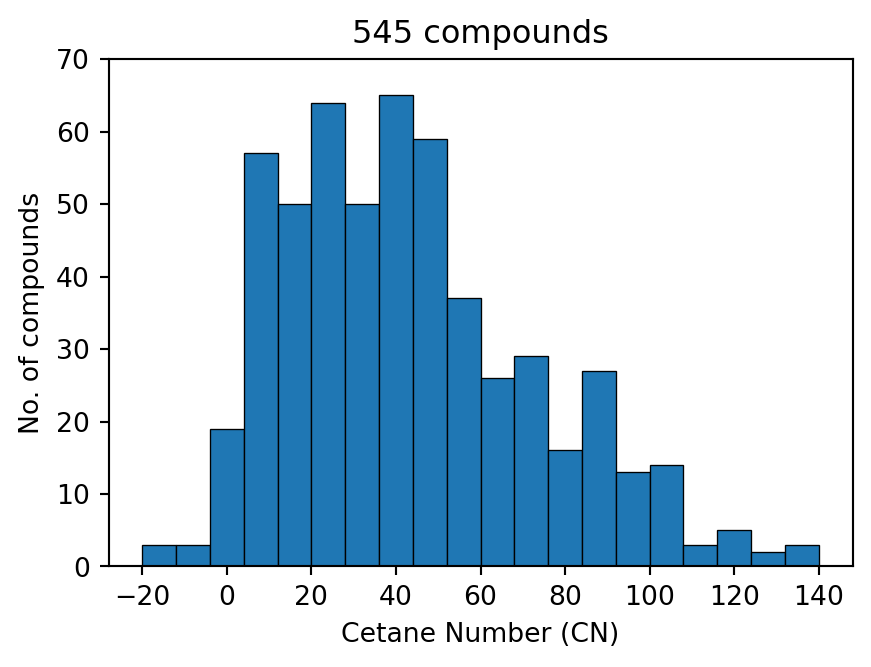

In [4]:
plot_histogram(Y, xlabel="Cetane Number (CN)")

## Mechanism of action signaturizer

Let us now compute the signaturizer descriptors:

In [5]:
sign = Signaturizer('B1') 
D = sign.predict(smiles).signature

2022-05-17 16:49:04.718790: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-17 16:49:04.718831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gpu2): /proc/driver/nvidia/version does not exist
2022-05-17 16:49:04.719268: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Define the partitions for cross-validation.

In [6]:
num_of_partitions = 10
kf = KFold(n_splits=num_of_partitions, shuffle=True, random_state=42)

We want to select a subset of descriptors that we will use to train the model.

In [7]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=15)

Define hyperparameters for the regression model:

In [8]:
param_grid = {
    'C': [1, 5, 7, 10, 30, 50, 100, 300, 500], 
    'epsilon': [0.1, 0.3, 1, 3, 5, 10, 20],
    'kernel': ['rbf']
}

Perform cross-validation:

In [9]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Use the selected descriptors to train an SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 10, 'epsilon': 10, 'kernel': 'rbf'}
Partition 2/10
{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 3/10
{'C': 30, 'epsilon': 10, 'kernel': 'rbf'}
Partition 4/10
{'C': 30, 'epsilon': 10, 'kernel': 'rbf'}
Partition 5/10
{'C': 30, 'epsilon': 5, 'kernel': 'rbf'}
Partition 6/10
{'C': 10, 'epsilon': 3, 'kernel': 'rbf'}
Partition 7/10
{'C': 5, 'epsilon': 5, 'kernel': 'rbf'}
Partition 8/10
{'C': 30, 'epsilon': 10, 'kernel': 'rbf'}
Partition 9/10
{'C': 7, 'epsilon': 5, 'kernel': 'rbf'}
Partition 10/10
{'C': 30, 'epsilon': 10, 'kernel': 'rbf'}
CPU times: user 2min 10s, sys: 0 ns, total: 2min 10s
Wall time: 2min 10s


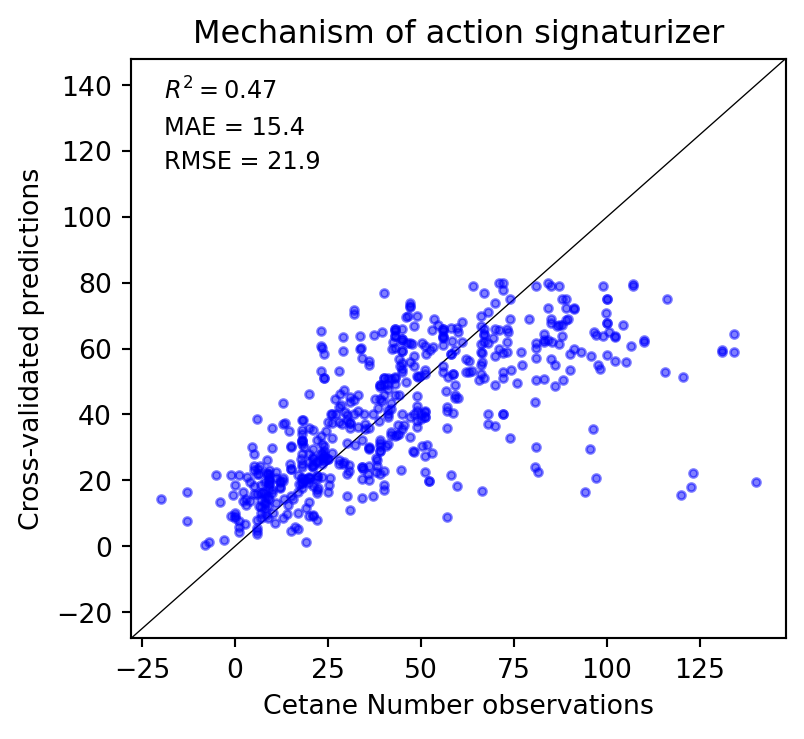

In [10]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            title='Mechanism of action signaturizer',
            savetitle='./results/CC/CN_B1signature.svg') 

Let us try other signaturizers:

## 2D fingerprints signaturizer

In [11]:
sign = Signaturizer('A1') 
D = sign.predict(smiles).signature

In [12]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Use the selected descriptors to train an SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 50, 'epsilon': 1, 'kernel': 'rbf'}
Partition 2/10
{'C': 50, 'epsilon': 10, 'kernel': 'rbf'}
Partition 3/10
{'C': 300, 'epsilon': 3, 'kernel': 'rbf'}
Partition 4/10
{'C': 500, 'epsilon': 20, 'kernel': 'rbf'}
Partition 5/10
{'C': 100, 'epsilon': 20, 'kernel': 'rbf'}
Partition 6/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 7/10
{'C': 5, 'epsilon': 0.3, 'kernel': 'rbf'}
Partition 8/10
{'C': 100, 'epsilon': 5, 'kernel': 'rbf'}
Partition 9/10
{'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 10/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
CPU times: user 2min 6s, sys: 53.1 ms, total: 2min 6s
Wall time: 2min 6s


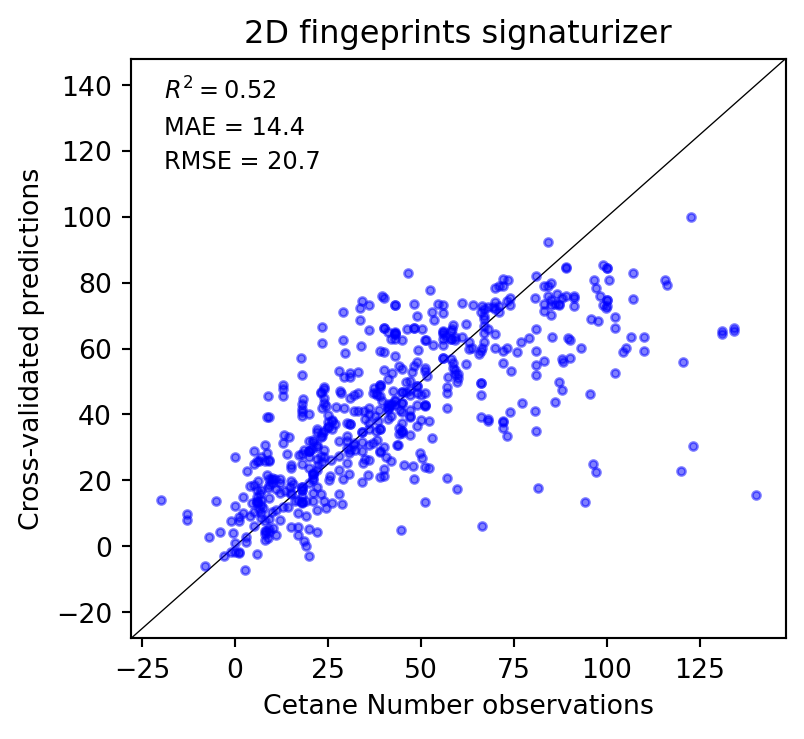

In [13]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            title='2D fingeprints signaturizer',
            savetitle='./results/CC/CN_A1signature.svg') 

## 3D fingerprints signaturizer

In [14]:
sign = Signaturizer('A2') 
D = sign.predict(smiles).signature

In [15]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Use the selected descriptors to train an SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 50, 'epsilon': 5, 'kernel': 'rbf'}
Partition 2/10
{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
Partition 3/10
{'C': 30, 'epsilon': 3, 'kernel': 'rbf'}
Partition 4/10
{'C': 300, 'epsilon': 10, 'kernel': 'rbf'}
Partition 5/10
{'C': 30, 'epsilon': 5, 'kernel': 'rbf'}
Partition 6/10
{'C': 30, 'epsilon': 10, 'kernel': 'rbf'}
Partition 7/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 8/10
{'C': 50, 'epsilon': 10, 'kernel': 'rbf'}
Partition 9/10
{'C': 10, 'epsilon': 10, 'kernel': 'rbf'}
Partition 10/10
{'C': 10, 'epsilon': 5, 'kernel': 'rbf'}
CPU times: user 2min 8s, sys: 81.9 ms, total: 2min 8s
Wall time: 2min 8s


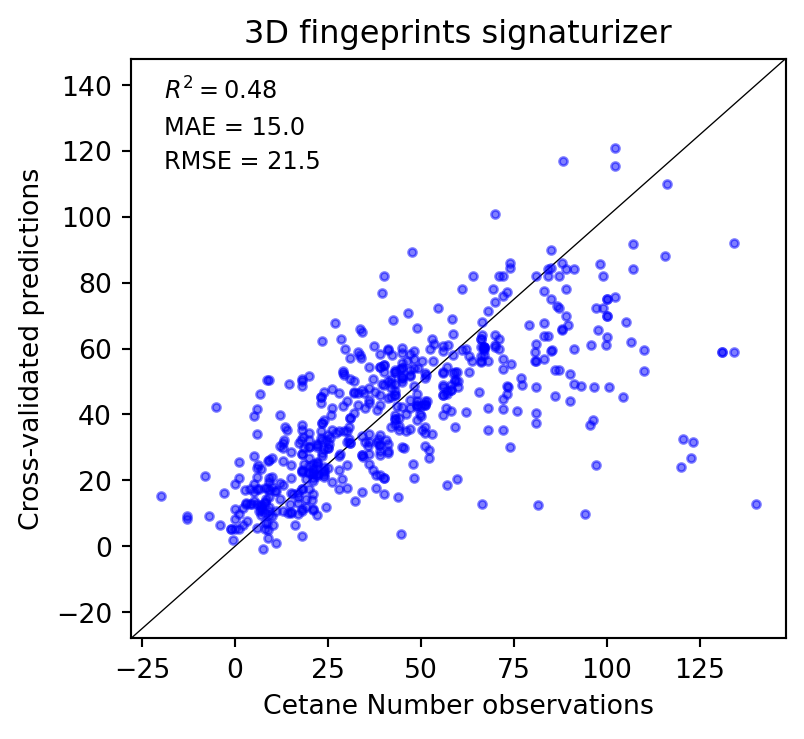

In [16]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            title='3D fingeprints signaturizer',
            savetitle='./results/CC/CN_A2signature.svg') 

## Physicochemistry signaturizer

In [18]:
sign = Signaturizer('A5') 
D = sign.predict(smiles).signature

In [19]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Use the selected descriptors to train an SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 30, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 2/10
{'C': 100, 'epsilon': 3, 'kernel': 'rbf'}
Partition 3/10
{'C': 500, 'epsilon': 5, 'kernel': 'rbf'}
Partition 4/10
{'C': 100, 'epsilon': 3, 'kernel': 'rbf'}
Partition 5/10
{'C': 100, 'epsilon': 3, 'kernel': 'rbf'}
Partition 6/10
{'C': 30, 'epsilon': 3, 'kernel': 'rbf'}
Partition 7/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 8/10
{'C': 300, 'epsilon': 10, 'kernel': 'rbf'}
Partition 9/10
{'C': 100, 'epsilon': 5, 'kernel': 'rbf'}
Partition 10/10
{'C': 50, 'epsilon': 0.1, 'kernel': 'rbf'}
CPU times: user 2min 7s, sys: 70.7 ms, total: 2min 7s
Wall time: 2min 7s


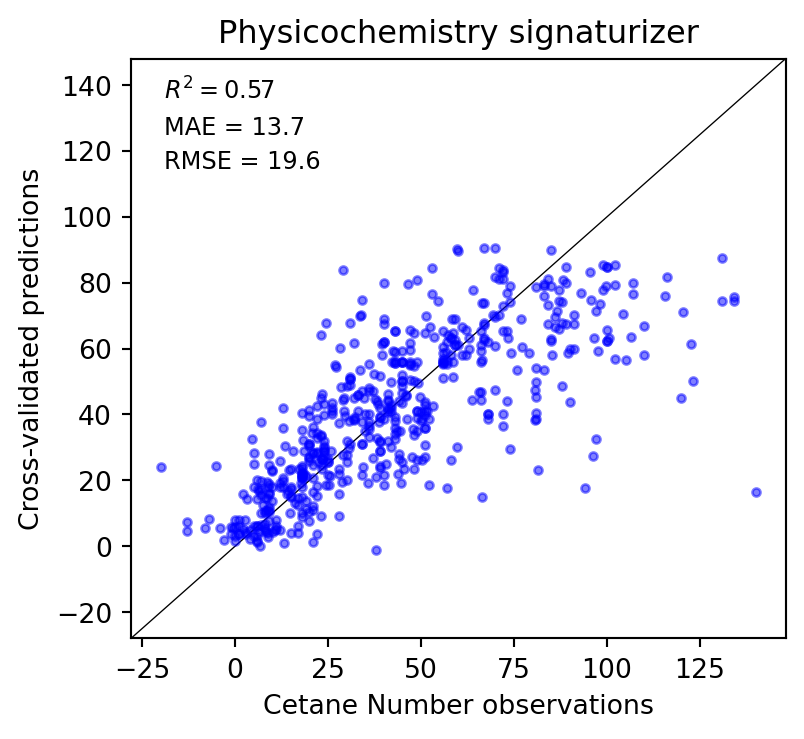

In [20]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            title='Physicochemistry signaturizer',
            savetitle='./results/CC/CN_A5signature.svg') 

## Cell-bioassay signaturizer

In [21]:
sign = Signaturizer('D5')
D = sign.predict(smiles).signature

In [22]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Use the selected descriptors to train an SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 2/10
{'C': 50, 'epsilon': 10, 'kernel': 'rbf'}
Partition 3/10
{'C': 50, 'epsilon': 5, 'kernel': 'rbf'}
Partition 4/10
{'C': 30, 'epsilon': 10, 'kernel': 'rbf'}
Partition 5/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 6/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 7/10
{'C': 100, 'epsilon': 3, 'kernel': 'rbf'}
Partition 8/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 9/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 10/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
CPU times: user 2min 11s, sys: 63.4 ms, total: 2min 11s
Wall time: 2min 11s


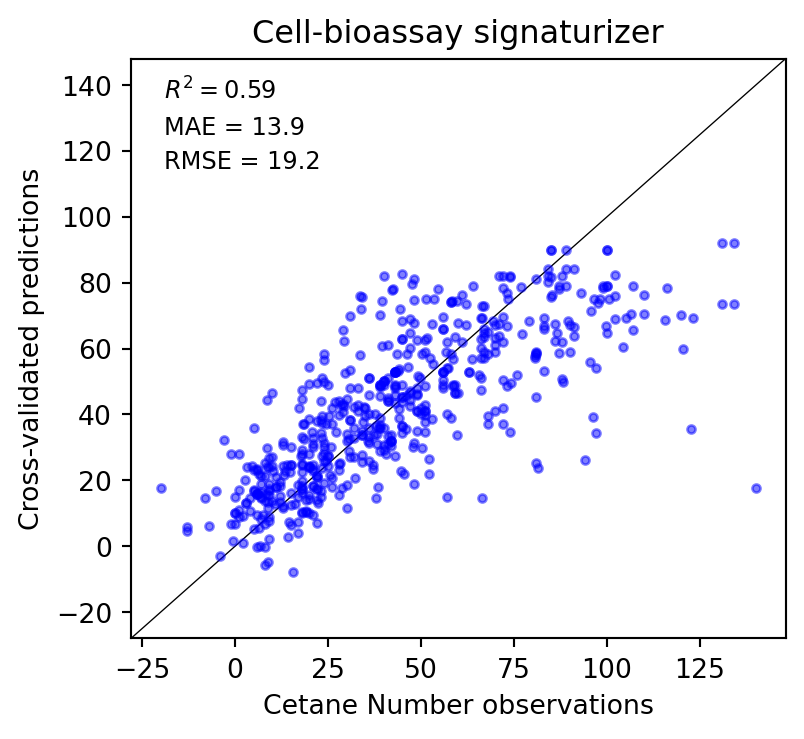

In [23]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            title='Cell-bioassay signaturizer',
            savetitle='./results/CC/CN_D5signature.svg') 

## Binding signaturizer

In [24]:
sign = Signaturizer('B4')
D = sign.predict(smiles).signature

In [25]:
%%time

Y_cv_pred = []
Y_obs = []

i = 1
for train_index, val_index in kf.split(D):
    print(f"Partition {i}/{num_of_partitions}")
    i+=1
    D_train , D_val = D[train_index, :], D[val_index, :]
    y_train , y_val = Y[train_index], Y[val_index]
    
    sfs.fit(D_train, y_train)
    
    X_train = sfs.transform(D_train)
    X_val = sfs.transform(D_val)
    
    # Use the selected descriptors to train an SVR model
    # Optimize hyperparameters
    grid = GridSearchCV(SVR(), param_grid, cv=5, refit=True)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # Test set predictions
    y_cv_pred = grid.predict(X_val)
    
    # Save corresponding validation instances
    Y_cv_pred.extend(y_cv_pred)
    Y_obs.extend(y_val)


Partition 1/10
{'C': 50, 'epsilon': 5, 'kernel': 'rbf'}
Partition 2/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 3/10
{'C': 30, 'epsilon': 3, 'kernel': 'rbf'}
Partition 4/10
{'C': 100, 'epsilon': 1, 'kernel': 'rbf'}
Partition 5/10
{'C': 10, 'epsilon': 5, 'kernel': 'rbf'}
Partition 6/10
{'C': 100, 'epsilon': 10, 'kernel': 'rbf'}
Partition 7/10
{'C': 30, 'epsilon': 5, 'kernel': 'rbf'}
Partition 8/10
{'C': 50, 'epsilon': 5, 'kernel': 'rbf'}
Partition 9/10
{'C': 30, 'epsilon': 0.1, 'kernel': 'rbf'}
Partition 10/10
{'C': 500, 'epsilon': 10, 'kernel': 'rbf'}
CPU times: user 2min 7s, sys: 86.6 ms, total: 2min 8s
Wall time: 2min 8s


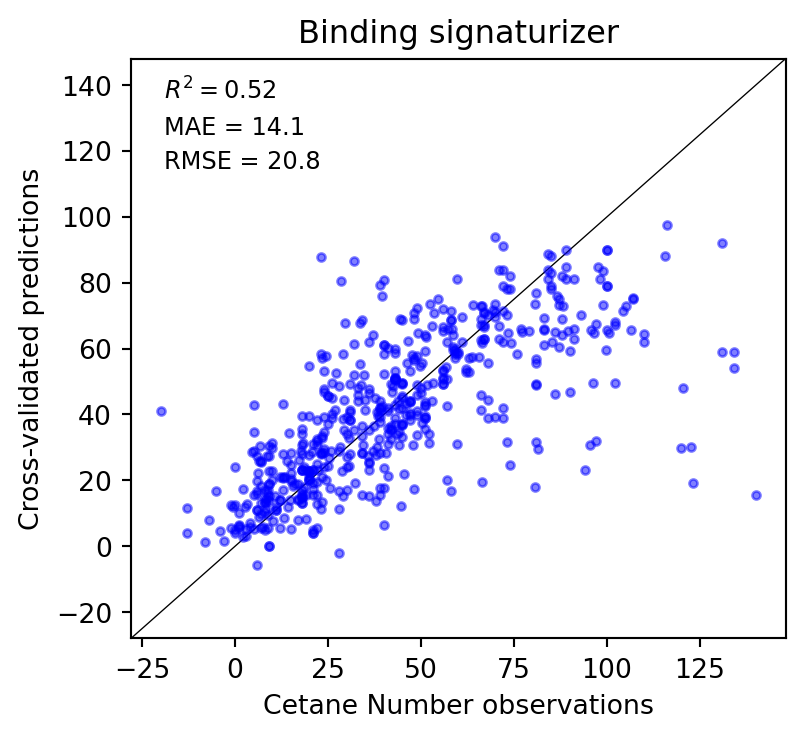

In [26]:
# Parity plot
parity_plot(x=Y_obs,
            y=Y_cv_pred, 
            xlabel="Cetane Number observations", 
            ylabel="Cross-validated predictions",
            title='Binding signaturizer',
            savetitle='./results/CC/CN_B4signature.svg') 